# navigation
if you want to skip to the exploratory analysis section, the only dataset you need is main_transformed.csv.

# packages

In [ ]:
# Sam Deery-Schmitt

import pandas as pd #data frame operations
import numpy as np #arrays and math functions
from scipy.stats import uniform #for training and test splits
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt #2D plotting
import requests # scraping
import lxml.html as lh #scraping
import seaborn as sns #visualiztions
import os # os operations
! pip install thefuzz
! pip install Levenshtein
from thefuzz import fuzz # fuzzy matching
from thefuzz import process # fuzzy matching
import Levenshtein as lev # increases speed of matching
import re # regular expressions
from google.colab import drive # view google drive in the files explorer on the left pane
from google.colab import files # upload files to google drive
drive.mount('/content/gdrive') # command to allow access

# workflow
load dataset
# df1 = pd.read_csv('df1.csv')
if dataset has conferences:
# df1 = alter_conferences(df1)
perform fuzzy matching
# matching_results = match_names(df1, coach, 'School', 'Conference')
# note: use 'School' as second column if no conference column in df1
identify errors in matching; will have to input values
# errors_output = match_error_identify(matching_results, df1, df2, 'School')
save this so you don't have to do it again
# errors = errors_output
identify indices in target df of mismatched columns
# indices_output = input_indices(errors, df1, 'School')
save output so you don't have to do again
# corrections = indices_output
change all values in df1 to match the values in df2
# df1 = correct_mismatch(corrections, matching_results, df1, df2, 'School')
pd.options.display.max_rows = len(df1)
df1

# concise workflow
# set df1 to the target dataframe
# set col2 to 'School' if there is no conference column
df1 = targetdf
df2 = coach
col1 = 'School'
col2 = 'Conference'
df1 = alter_conferences(df1)

# seperate block
matching_results = match_names(df1, coach, col1, col2)
errors_output = match_error_identify(matching_results, df1, df2, 'School')

# separate block
errors = errors_output
indices_output = input_indices(errors, df1, col1)

# separate block
corrections = indices_output
df1 = correct_mismatch(corrections, matching_results, df1, df2, 'School')

# seperate block
pd.options.display.max_rows = len(df1)
df1

#unique list function
#used to capture unique list of conferences from target df within the confs_fix function

In [ ]:
def unique(list1):

    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return(unique_list)

#function for changing conferences
# use:
#df1 = alter_conferences(df1)
#assumes the conference column is called Conference
#output is the reformatted df

In [ ]:
def alter_conferences(df1):
  # note: this will only work if all 11 FBS conferences are actually there
  # if they aren't, don't use it
  original_length = len(df1)
  confs = unique(df1['Conference'].sort_values())
  print('The conferences in this dataframe are:')
  for i in range(0, len(confs)):
    print(i, confs[i])

  # these are the "properly formatted" names of the FBS conferences
  master_confs = []
  master_confs = ['American', 'ACC', 'Big 12', 'Big Ten', 'Conference USA', 'FBS Independents'
  , 'Mid-American', 'Mountain West', 'Pac-12', 'SEC', 'Sun Belt']
  print('\n The 11 FBS conferences are:')
  for i in range(0, len(master_confs)):
    print(master_confs[i])
  print('\n')

  # prompt for input of indices
  fbs_confs = input('Type the indices of the FBS conferences in the target DF \n separated by commas with no spaces:\n')
  # convert input to list
  fbs_confs = list(fbs_confs.split(','))
  #convert str values to int
  confs_index = []
  for i in fbs_confs:
   confs_index.append(int(i))
   # use these indices to retrive the fbs conferences in the target df
  confs_interest = []
  for i in confs_index:
    confs_interest.append(confs[i])
  # make a dictionary that has the conference name of target df as key
  # and "master" fbs conf name as a value
  confs_dict = {}
  for i in range(0, len(confs_interest)):
    confs_dict[confs_interest[i]] = master_confs[i]

  # print the confs dict so can spot mistakes if any
  print('\n Here is the dictionary creatd by the input values\n')
  for i in confs_dict:
    print(i,'|', confs_dict[i])
  # alter the target dataframe
  for i in range(0,len(df1['Conference'])):
    if df1['Conference'][i] in confs_dict.keys():
       df1['Conference'][i] = confs_dict[df1['Conference'][i]]
    else:
      continue
  # subset the target df to only include FBS conferences
  df1 = df1[df1['Conference'].isin(master_confs)]
  new_length = len(df1)
  change = original_length - new_length
  new_confs = df1['Conference'].unique()
  new_confs = sorted(new_confs)
  print('\n',change, 'records deleted', '\n', len(confs), 'conferences originally in target df',
          '\n', len(df1['Conference'].unique()), 'FBS conferences in target DF now have properly formatted names:\n')
  for i in range(0, len(new_confs)):
    print(i+1, new_confs[i])
  return(df1)

# fuzzy matching function
# use:
# matching_names = match_names(df1, df2, col1, col2)

# input the "matched against" df first, then the original second
# put the names of columns to use here
# this assumes coach will be used second, and the columns 'School' and 'Conference' in that order
# output is results of fuzzy matching


In [ ]:
def match_names(df1, df2, col1, col2):
  df1['JoinCol'] = df1[col1] + ', ' + df1[col2]
  df2['JoinCol'] = df2[col1] + ', ' + df2[col2]
  results = []
  for ind in df2.index:
    query = df2['JoinCol'][ind]
    choices = df1['JoinCol']
    match = process.extractOne(query, choices)
    match = (ind, ) + match
    results.append(match)
  match_info = []
  for i in results:
    match_info.append([i[2], i[0], df2[col1][i[0]], df1[col1][i[3]], i[3]])
  return(match_info)

# called within the match_error_identify function
function to remove falsely identified mismatches and create final errors list
input is the potential errors list and certain errors list
user will input the error indices
returns final list of errors

In [ ]:
def finalize_errors_list(potential_errors, certain_errors):
  for i in range(0, len(potential_errors)):
    print(i, potential_errors[i])
  e_indices = input('Type the indices of the actual errors F \n separated by commas with no spaces:\n')
  # convert input to list
  e_indices = list(e_indices.split(','))
  #convert str values to int
  indices = []
  for i in e_indices:
    if i != '':
      indices.append(int(i))
  bridge = []
  for i in indices:
    bridge.append(potential_errors[i])
  errors = []
  for i in certain_errors:
    errors.append(i)
  for i in bridge:
    errors.append(i)
  return(errors)

# error identification function
# use:
# errors_output = match_error_identify(match_results, df1,df2, col1)
# errors = errors_ouput
# this function finds all matches with less than 100 score
# and all matches that are duplicates
# then it pares the duplicates down to only duplicates with less than 100 score
# those are certain errors, and will all be contained in the list of
# matches with less than 100
# it then removes those from that list
# and those records are marked as potential errors, because they are either false positives
# or they are records that exist in orginal df but not target df
# then it allows the user to manually inspect the errors and remove any false positives
# finally returning a list of certain errors

In [ ]:
def match_error_identify(match_results, df1, df2, col1):
  errors = []
  for i in match_results:
    if i[0] != 100:
      errors.append(i)
  # ANYTHING that is duplicated AND has a score less than 100 is incorrect
  # BUT this doesn't capture all errors,
  # for example, records in the original dataframe that are missing in the new dataframe
  schools = []
  for i in match_results:
    schools.append(i[3])
  import collections
  duplicated_schools = ([item for item, count in collections.Counter(schools).items() if count > 1])
  duplicates = []
  for i in match_results:
    if i[3] in duplicated_schools:
      duplicates.append(i)
  duplicates
  errors2 = []
  for i in duplicates:
    if i[0] != 100:
      errors2.append(i)
  # the UNION of these are certainly errors
  # everything in the duplicates will be found in the list
  # of items with less than 100 score
  # but the items NOT FOUND in the duplicates
  # which are found in the list of less than 100
  # might be errors
  potential_errors = []
  for i in errors:
    if i not in errors2:
      potential_errors.append(i)
  certain_errors  = []
  for i in errors:
    if i in errors2:
      certain_errors.append(i)
  print('', len(df2), 'records in original DF', '\n', len(df1), 'records in target DF', '\n',
        len(certain_errors), 'certain errors, can include mismatches or records that exist in orignal df but not target df',
        '\n', len(potential_errors),
        'potential errors, can include mismatches, records missing from target DF, OR false positives (matches marked as mismatches))' )
  errors = finalize_errors_list(potential_errors, certain_errors)
  # set the final item in each error to be None for easier editing
  for i in errors:
    i[4] = None
  pd.options.display.max_rows = len(df1)
  print('\n', len(errors), 'total errors:')
  for i in (range(0, len(errors))):
    print(i, errors[i])
  print('\n make sure to save the output so this step does not need to be repeated \n here is the target DF for reference during error ID in next step')
  print(df1[col1].sort_values())
  return errors

# error correction function
# use:
# corrections_ouput = input_indices(errors, df1, col)
# corrections = corrections_output
# this will give a list of the indices in target df to swap out
# will have to input the indices manually, function will ask for them line by line

In [ ]:
def input_indices(errors, df1, col1):
  skip = input('do you already know the indices? if so type something and this will not run\n make sure you have the output saved somewhere before terminating this')
  if skip != '':
    return('you should have the output saved as a list containing the og df school name, target df school name, and target df index')
  else:
    print('if this school exists in target DF, enter its index \n otherwise just hit enter')
    index = []
    for i in range(0,len(errors)):
      index.append([i, input(print(i, errors[i]))])
    for i in index:
      if i[1] != '':
        i[1] = int(i[1])
      else:
        i[1] = None
    correct_indices = []
    for i in range(0, len(errors)):
      if index[i][1] != None:
        correct_indices.append([errors[i][0], errors[i][1], errors[i][2], df1[col1][index[i][1]], index[i][1]])
      else:
        correct_indices.append([errors[i][0], errors[i][1], errors[i][2], 'MISSING', index[i][1]])
  return(correct_indices)

# final matching function
# use:
# df1 = correct_mismatch(corrections, match_results, df1, df2, dfcol)

In [ ]:
def correct_mismatch(corrections, match_results, df1, df2, dfcol):
  match_col_to_sort = 3
  match_cols_to_drop = [0,1,4]
  correct_indices = []
  for i in corrections:
    if i[4] != None:
      correct_indices.append(i[4])
  original_target_df_length = len(df1)
  missing_records = len(corrections) - len(correct_indices)
  new_length = len(df2) - missing_records
  print(len(correct_indices), 'substitutions need to be made in matching results', '\n and', missing_records, 'records from og df not present in target df',
        '\n therefore the new target df should have', new_length, 'records')
  df_mapping = pd.DataFrame(match_results)
  df_corrections = pd.DataFrame(corrections)
  # swap out name and index for mistaken schools
  for i in range(0, len(df_mapping[0][df_corrections[0]])):
    df_mapping[3][df_corrections[1][i]] = df_corrections[3][i]
    df_mapping[4][df_corrections[1][i]] = df_corrections[4][i]
  # eliminate records from col not in original df
  df1 = df1[df1[dfcol].isin(df_mapping[3])]
  # change values in target df to match original df
  df_mapping = df_mapping.sort_values(by = 3)
  df1 = df1.sort_values(by = dfcol)
  df_mapping = df_mapping[df_mapping[3] != 'MISSING']
  df_mapping = df_mapping.drop(columns = match_cols_to_drop)
  df_mapping = df_mapping.rename(columns = {match_col_to_sort-1: dfcol, match_col_to_sort: 'TargetDFFormerName'})

  # see if columns are identical
  if df_mapping[dfcol].reset_index(drop=True).equals(df1[dfcol].reset_index(drop=True)) == True:
    # now has the proper names and conferences and is in same order as coach, they can be merged
    # you have caught all records that were missing from original df in target df
    print('Target DF records now match orginal DF records in col of interest, and are same order; they can now be merged. \n There were no missing records from coach df in new df')
    print(len(df1), 'records')
    df1 = df1.reset_index(drop = True)
    df_mapping = df_mapping.reset_index(drop = True)
    df1[dfcol] = df_mapping[dfcol]
    df1 = df1.sort_values(by = dfcol)
    df1 = df1.reset_index(drop = True)
    pd.options.display.max_rows = len(df1)
    return(df1)

  elif len(df_mapping) == new_length:
    print('After matching names, there were still', original_target_df_length - new_length, 'records missing from og df in new df')
    df1 = df1.reset_index(drop = True)
    df_mapping = df_mapping.reset_index(drop = True)
    df1[dfcol] = df_mapping[dfcol]
    df1 = df1.sort_values(by = dfcol)
    df1 = df1.reset_index(drop = True)
    print(len(df1), 'records in new df')
    pd.options.display.max_rows = len(df1)
    return(df1)


  else:
    print('There is a mistake somewhere. The dataframes do not allign.','\nreturning mapping DF for analysis \n might want to run fuzzy matching on the mapping df to find the problems')
    print(len(df_mapping), 'records')
    pd.options.display.max_rows = len(df_mapping)
    return(df_mapping)


# import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read in coaches dataframe from github
coach = pd.read_csv('https://raw.githubusercontent.com/2SUBDA/IST_718/master/Coaches9.csv')
# change default pandas display options to show more rows
# pd.options.display.max_rows = 150
# coach
# rename to USC
coach[coach.School == 'Southern California']
coach['School'][98] = 'USC'
# rename conferences
confs = coach['Conference'].sort_values().unique()

master_confs = []
master_confs = ['American', 'ACC', 'Big 12', 'Big Ten', 'Conference USA', 'FBS Independents'
, 'Mid-American', 'Mountain West', 'Pac-12', 'SEC', 'Sun Belt']

confs_dict = {}
for i in range(0, len(confs)):
  confs_dict[confs[i]] = master_confs[i]

for i in range(0, len(coach['Conference'])):
  coach['Conference'][i] = confs_dict[coach['Conference'][i]]

In [ ]:
# displays working drive
os.getcwd()

'/content'

In [ ]:
# upload the following files:
# grad_rates.csv
# revenues.csv
# enrollment.csv
# 2017_season.csv
uploaded = files.upload()

Saving 2017_season.csv to 2017_season.csv
Saving enrollment.csv to enrollment.csv
Saving grad_rates.csv to grad_rates.csv
Saving revenues.csv to revenues.csv


# sources

In [ ]:
# information about the data
# didn't scrape several of these sites because it's historical data
# if this were frequently changing data I would have set up an ETL pipeline, scraping everything

# coach
# pulled from this class's github
# 'https://raw.githubusercontent.com/2SUBDA/IST_718/master/Coaches9.csv'

# graduation rates
# copied and pasted from this URL then cleaned in Excel before saving as a .csv
# used the following search paramters:
# School: All, Conference: All, Sport: Football, Year: 2020-2021, State: All
# was more time-efficient than scraping the dynamic table
# https://web3.ncaa.org/aprsearch/gsrsearch

# stadiums is scraped from
# https://www.collegegridirons.com/comparisons-by-capacity/

# enrollment
# https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_programs
# copied and pasted into excel, faster than scraping
# revenues
# this came from https://graphics.wsj.com/table/NCAA_2019
# copied and pasted into excel, kept only School and Revenue columns, converted revenue to number

# season
# https://www.sports-reference.com/cfb/years/2017-standings.html
# could have scraped these tables but it was just easier to download and edit in excel
# deleted some columns and converted several to number

# the final dataset is just called main, i downloaded it as main_transformed.csv once i was done creating it, cleaning it, and transforming it
# you can skip right to exploratory analysis section if you use that dataset otherwise you ahve to upload the aforementiond csvs except the scraped one and the one pulled from github
# i could put them on github but it's fine no one else is using this

In [ ]:
# scrape stadium capacity data
# this will only scrape a static table

url='https://www.collegegridirons.com/comparisons-by-capacity/'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
tr_elements = doc.xpath('//tr')
#Create empty list for the headers
headers=[]
i=0
#For each row, store each first element (header)
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print (i,name)
    headers.append((name))

# create a list containing a string for each record

tr_elements = doc.xpath('//tbody')
#Create empty list
col=[]
i=0
#For each row, store each first element (header)
for t in tr_elements[0]:
    i+=1
    # record = []
    data=t.text_content()
    # record.append(data)
    col.append((data))
print(col[:5])

# convert all records to lists
for i in range(0,len(col)):
  text = re.sub(',' , '' , col[i])
  text = re.sub('\n', ',' , text)
  text = text[1:-1]
  text = text.split(",")
  col[i] = text

# convert list of lists to pandas dataframe
stadiums = pd.DataFrame(col, columns = headers)
del stadiums['Stadium'], stadiums['Opened']

# change datatype of capacity to int
stadiums = stadiums.astype({'Capacity': 'int'})

# rename school column
stadiums = stadiums.rename(columns = {'College' : 'School'})
# stadiums.dtypes
stadiums['Conference'].unique()

1 Stadium
2 College
3 Conference
4 Capacity
5 Opened
['\nMichigan Stadium\nMichigan\nBig Ten\n107,601\n1927\n', '\nBeaver Stadium\nPenn State\nBig Ten\n106,572\n1960\n', '\nOhio Stadium\nOhio State\nBig Ten\n104,944\n1922\n', '\nKyle Field\nTexas A&M\nSEC\n102,733\n1904\n', '\nNeyland Stadium\nTennessee\nSEC\n102,521\n1921\n']


array(['Big Ten', 'SEC', 'Big 12', 'Pac 12', 'ACC', 'Independent', 'CUSA',
       'Mountain West', 'MAC', 'AAC', 'Sun Belt'], dtype=object)

In [ ]:
# Upon inspecting stadiums df and the actual webpage, realized that for some reaosn
# liberty and TCU were not scraped from the site
# manually adding the schools now
# first make a new datframe then use append to add them as rows at the bottom
missing_dict = {'School': ['Liberty', 'Texas Christian'],
                    'Conference' : ['Independent', 'Big 12'],
                    'Capacity': [25000, 45000],
                    }
missing_stadiums = pd.DataFrame.from_dict(missing_dict)
stadiums = stadiums.append(missing_stadiums, ignore_index = True)

<ipython-input-15-178be323e1e2>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stadiums = stadiums.append(missing_stadiums, ignore_index = True)


# perform fuzzy matching for all dataframes

In [ ]:
# set df1 to the target dataframe
# set col2 to 'School' if there is no conference column
df1 = grad_rates
df2 = coach
col1 = 'School'
col2 = 'Conference'
df1 = alter_conferences(df1)

# seperate block
matching_results = match_names(df1, coach, col1, col2)
errors_output = match_error_identify(matching_results, df1, df2, 'School')

# separate block
errors = errors_output
indices_output = input_indices(errors, df1, col1)

# separate block
corrections = indices_output
df1 = correct_mismatch(corrections, matching_results, df1, df2, 'School')

# seperate block
pd.options.display.max_rows = len(df1)
df1

# grad rates

In [ ]:
grad_rates = pd.read_csv('grad_rates.csv')
# set df1 to the target dataframe
# set col2 to 'School' if there is no conference column

# there are some trailing whitespaces that are messing up the matching function
# even though it removes whitespace soem still remain so this will fix that
grad_rates['School'] = grad_rates['School'].str.strip()
grad_rates = alter_conferences(grad_rates)
# indices to input:
# 0,1,2,5,7,9,10,13,16,19,23

In [ ]:
df1 = grad_rates
df2 = coach
col1 = 'School'
col2 = 'Conference'

In [ ]:
matching_results = match_names(df1, df2, col1, col2)

In [ ]:
errors_output = match_error_identify(matching_results, df1, df2, 'School')
# 0,2

In [ ]:
errors = errors_output
errors

In [ ]:
indices_output = input_indices(errors, df1, col1)

In [ ]:
corrections = indices_output
corrections

In [ ]:
corrections = [[86, 7, 'Arkansas', 'Arkansas, Fayetteville', 12],
 [86, 17, 'Buffalo', 'at Buffalo, the State  New York', 26],
 [86, 27, 'Connecticut', 'Connecticut', 46],
 [86, 42, 'Illinois', 'Illinois Urbana-Champaign', 85],
 [86, 43, 'Indiana', 'Indiana , Bloomington', 87],
 [86, 55, 'LSU', 'Louisiana State', 101],
 [86, 57, 'Maryland', 'Maryland, College Park', 107],
 [86, 60, 'Miami (Fla.)', 'Miami (Florida)', 114],
 [86, 65, 'Minnesota', 'Minnesota, Twin Cities', 118],
 [86, 68, 'Missouri', 'Missouri, Columbia', 122],
 [86, 70, 'Nebraska', 'Nebraska, Lincoln', 131],
 [95, 75, 'North Carolina', 'North Carolina, Chapel Hill', 129],
 [86, 92, 'Rutgers', 'Rutgers, The State  New Jersey, New Brunswick', 172],
 [86, 96, 'South Carolina', 'South Carolina, Columbia', 182],
 [87, 98, 'USC', 'Southern California', 188],
 [86, 103, 'Tennessee', 'Tennessee, Knoxville', 206],
 [95, 104, 'Texas', 'Texas at Austin', 212],
 [86, 105, 'Texas A&M', 'Texas A&M , College Station', 208],
 [90, 18, 'California', 'California, Berkeley', 31],
 [86, 25, 'Colorado', 'Colorado, Boulder', 44]]

In [ ]:
test = correct_mismatch(corrections, matching_results, df1, df2, 'School')

In [ ]:
pd.options.display.max_rows = 150
grad_rates = test

In [ ]:
grad_rates.to_csv('matched_grad_rates.csv')

# stadiums

In [ ]:
# set df1 to the target dataframe
# set col2 to 'School' if there is no conference column
df1 = stadiums
df2 = coach
col1 = 'School'
col2 = 'Conference'
stadiums = alter_conferences(df1)

In [ ]:
df1 = stadiums

In [ ]:
matching_results = match_names(df1, coach, col1, col2)
errors_output = match_error_identify(matching_results, df1, df2, 'School')

In [ ]:
errors = errors_output
indices_output = input_indices(errors, df1, col1)

In [ ]:
corrections = indices_output

In [ ]:
corrections = [[86, 3, 'Alabama at Birmingham', 'UAB', 22],
 [85, 16, 'Brigham Young', 'BYU', 35],
 [85, 58, 'Massachusetts', 'Umass', 27],
 [95, 61, 'Miami (Ohio)', 'Miami-OH', 117],
 [95, 72, 'Nevada-Las Vegas', 'UNLV', 87],
 [86, 74, 'New Mexico State', 'New Mexico State', 101],
 [95, 76, 'North Carolina State', 'NC State', 48],
 [86, 109, 'Texas-El Paso', 'UTEP', 59],
 [86, 110, 'Texas-San Antonio', 'UTSA', 33],
 [86, 99, 'Southern Methodist', 'SMU', 92]]

In [ ]:
df1 = correct_mismatch(corrections, matching_results, df1, df2, 'School')

In [ ]:
pd.options.display.max_rows = len(df1)
stadiums = df1

In [ ]:
stadiums.to_csv('matched_stadiums.csv')

# enrollment

In [ ]:
enrollment = pd.read_csv('enrollment.csv')
# set df1 to the target dataframe
# set col2 to 'School' if there is no conference column
df2 = coach
col1 = 'School'
col2 = 'Conference'
enrollment = enrollment.rename(columns = {'Current Conf': 'Conference', 'Team' : 'School'})

enrollment[enrollment.Conference == 'American[n 3]']
enrollment['Conference'] = enrollment['Conference'].replace({'American[n 3]': 'American', 'Big 12[n 10]' : 'Big 12', 'C-USA[n 4]' : 'C-USA', 'Independent[n 3]' : 'Independent', 'Independent[n 6]' : 'Independent'  })
enrollment = alter_conferences(enrollment)
# 1,0,2,3,4,5,6,7,8,9,10
df1 = enrollment

In [ ]:
matching_results = match_names(df1, coach, col1, col2)

In [ ]:
errors_output = match_error_identify(matching_results, df1, df2, 'School')

In [ ]:
errors = errors_output
indices_output = input_indices(errors, df1, col1)

In [ ]:
corrections = indices_output

In [ ]:
corrections = [[86, 3, 'Alabama at Birmingham', 'UAB', 108],
 [85, 16, 'Brigham Young', 'BYU', 16],
 [86, 19, 'Central Florida', 'UCF', 109],
 [86, 27, 'Connecticut', 'UConn', 111],
 [86, 33, 'Florida International', 'FIU', 28],
 [84, 56, 'Marshall', 'Marshall', 53],
 [85, 58, 'Massachusetts', 'UMass', 112],
 [95, 66, 'Mississippi', 'Mississippi State', 62],
 [95, 72, 'Nevada-Las Vegas', 'UNLV', 113],
 [95, 76, 'North Carolina State', 'NC State', 65],
 [84, 85, 'Old Dominion', 'Old Dominion', 79],
 [86, 99, 'Southern Methodist', 'SMU', 90],
 [86, 100, 'Southern Mississippi', 'Southern Miss', 94],
 [86, 106, 'Texas Christian', 'TCU', 97],
 [86, 109, 'Texas-El Paso', 'UTEP', 115],
 [86, 110, 'Texas-San Antonio', 'UTSA', 116]]

In [ ]:
df1 = correct_mismatch(corrections, matching_results, df1, df2, 'School')

In [ ]:
pd.options.display.max_rows = len(df1)
enrollment = df1

In [ ]:
enrollment.to_csv('matched_enrollment.csv')

# revenues

In [ ]:
revenues = pd.read_csv('revenues.csv')
# set df1 to the target dataframe
# set col2 to 'School' if there is no conference column
df1 = revenues
df2 = coach
col1 = 'School'
col2 = 'School'

In [ ]:
matching_results = match_names(df1, df2, col1, col2)
errors_output = match_error_identify(matching_results, df1, df2, 'School')
# 1,2,5

In [ ]:
errors = errors_output
indices_output = input_indices(errors, df1, col1)

In [ ]:
corrections = indices_output
corrections = [[67, 0, 'Air Force', 'MISSING', None],
 [86, 3, 'Alabama at Birmingham', 'UAB', 70],
 [86, 4, 'Appalachian State', 'MISSING', None],
 [64, 9, 'Army', 'MISSING', None],
 [58, 21, 'Charlotte', 'MISSING', None],
 [84, 24, 'Coastal Carolina', 'MISSING', None],
 [86, 37, 'Georgia Southern', 'MISSING', None],
 [86, 38, 'Georgia State', 'MISSING', None],
 [64, 58, 'Massachusetts', 'MISSING', None],
 [86, 67, 'Mississippi State', 'Miss State', 34],
 [86, 72, 'Nevada-Las Vegas', 'UNLV', 84],
 [54, 85, 'Old Dominion', 'MISSING', None],
 [86, 95, 'South Alabama', 'MISSING', None],
 [67, 98, 'USC', 'Southern California', 22],
 [86, 100, 'Southern Mississippi', 'Southern Miss', 100],
 [86, 107, 'Texas State', 'MISSING', None],
 [86, 109, 'Texas-El Paso', 'UTEP', 91],
 [86, 110, 'Texas-San Antonio', 'MISSING', None],
 [67, 113, 'Tulane', 'MISSING', None],
 [73, 114, 'Tulsa', 'MISSING', None],
 [86, 123, 'Washington State', 'Wash State', 51],
 [86, 18, 'California', 'California Berkeley', 39],
 [50, 50, 'Liberty', 'MISSING', None],
 [60, 69, 'Navy', 'MISSING', None]]

In [ ]:
revenues = correct_mismatch(corrections, matching_results, df1, df2, 'School')

In [ ]:
pd.options.display.max_rows = 150
revenues

In [ ]:
revenues.to_csv('matched_revenues.csv')

# season

In [ ]:
season_2017 = pd.read_csv('2017_season.csv')
# set df1 to the target dataframe
# set col2 to 'School' if there is no conference column
df1 = grad_rates
df2 = coach
col1 = 'School'
col2 = 'Conference'
season_2017

season_2017 = season_2017.rename(columns = {'Conf': 'Conference'})
season_2017['Conference'].unique()

season_2017['Conference'] = season_2017['Conference'].replace({'ACC (Atlantic)': 'ACC', 'ACC (Coastal)' : 'ACC', 'American (East)' : 'American', 'American (West)' : 'American',
                                                               'Big Ten (East)' : 'Big Ten', 'Big Ten (West)': 'Big Ten', 'CUSA (East)': 'CUSA', 'CUSA (West)': 'CUSA', 'MAC (East)' : 'MAC',
                                                               'MAC (West)' : 'MAC', 'MWC (Mountain)' : 'MWC', 'MWC (West)': 'MWC', 'Pac-12 (North)' : 'Pac-12', 'Pac-12 (South)' : 'Pac-12',
                                                               'SEC (East)' : 'SEC', 'SEC (West)' : 'SEC',})
season_2017['Conference'].unique()
season_2017 = alter_conferences(season_2017)
# 1,0,2,3,4,5,6,7,8,9,10
df1 = season_2017

In [ ]:
matching_results = match_names(df1, coach, col1, col2)
errors_output = match_error_identify(matching_results, df1, df2, 'School')

In [ ]:
errors = errors_output
indices_output = input_indices(errors, df1, col1)

In [ ]:
corrections = indices_output

In [ ]:
corrections = [[86, 3, 'Alabama at Birmingham', 'UAB', 59],
 [85, 16, 'Brigham Young', 'BYU', 67],
 [86, 19, 'Central Florida', 'UCF', 14],
 [87, 50, 'Liberty', 'MISSING', None],
 [86, 52, 'Louisiana-Lafayette', 'Louisiana', 125],
 [95, 66, 'Mississippi', 'Ole Miss', 116],
 [86, 74, 'New Mexico State', 'New Mexico State', 124],
 [86, 89, 'Pittsburgh', 'Pitt', 12],
 [86, 99, 'Southern Methodist', 'SMU', 23],
 [86, 109, 'Texas-El Paso', 'UTEP', 63],
 [86, 110, 'Texas-San Antonio', 'UTSA', 61]]

In [ ]:
df1 = correct_mismatch(corrections, matching_results, df1, df2, 'School')

In [ ]:
pd.options.display.max_rows = len(df1)
season_2017 = df1
season_2017

In [ ]:
season_2017.to_csv('matched_season_2017.csv')

# merge dataframes

In [ ]:
main = coach
main = main.drop(['TotalPay', 'JoinCol', 'AssistantPay', 'Buyout'], axis = 1)

grad_rates = grad_rates[['School', 'GSR', 'FGR']]
stadiums = stadiums[['School', 'Capacity']]
enrollment = enrollment[['School', 'Enrollment']]
revenues = revenues[['School', 'Revenues']]
season_2017 = season_2017[['School', 'W', 'L', 'Pct', 'Conf_W', 'Conf_L', 'Conf_Pct', 'AP High', 'AP Rank']]

def merge_df(df1, main, col, method):
  main = main.merge(df1, on = col, how = method)
  return(main)

col = 'School'
method = 'left'

main = merge_df(grad_rates, main, col, method)
main = merge_df(stadiums, main, col, method)
main = merge_df(enrollment, main, col, method)
main = merge_df(revenues, main, col, method)
main = merge_df(season_2017, main, col, method)
pd.options.display.max_columns = 40
pd.options.display.max_rows = 10
main = main.replace({'--': None})
main.to_csv('main.csv')
main

# cleaning
# can start here by uploading main

In [ ]:
uploaded = files.upload()

Saving main_transformed.csv to main_transformed.csv


In [ ]:
main = pd.read_csv('main.csv')

In [ ]:
# i forgot to set index = false when saving the main dataframe as a csv
# this deletes that index column
main = main.drop(['Unnamed: 0', 'AssistantPay'], axis = 1)

In [ ]:
# total NAs
main.isnull().sum().sum()

In [ ]:
for i in main.columns:
  print(i, main[i].isnull().sum())
'''
School 0
Conference 0
Coach 0
SchoolPay 4
Bonus 22
BonusPaid 41
Buyout 22
GSR 0
FGR 0
Capacity 0
Enrollment 18
Revenues 16
W 1
L 1
Pct 1
Conf_W 4
Conf_L 4
Conf_Pct 5
AP High 85
AP Rank 104
'''

In [ ]:
for i in main.columns:
  print(i,':',main[i].dtypes)

In [ ]:
# get rid of the characters we don't want (tulsa has [] in it for some reason in enrollment)
main = main.replace(to_replace=r'[$,\[\]]', value='', regex=True)
main

In [ ]:
# convert the strings to float (will convert to int later, i think converting to int requires NAs to be changed to a value)
main['SchoolPay'] = pd.to_numeric(main.SchoolPay, errors='coerce')
main['Bonus'] = pd.to_numeric(main.Bonus, errors='coerce')
main['BonusPaid'] = pd.to_numeric(main.BonusPaid, errors='coerce')
main['Buyout'] = pd.to_numeric(main.Buyout, errors='coerce')
main['Enrollment'] = pd.to_numeric(main.Enrollment, errors='coerce')
for i in main.columns:
  print(i,':',main[i].dtypes)
main

In [ ]:
# schoolpay NAs
# it's NA because it's not publicly available
# can use median by conference

# there's so much data missing about Liberty that i'm just going to delete it

# for bonus and bonus paid:
# calculate the median percent of schoolpay that a bonus is, and the average percent of a bonus a coach earns
# do that by conference

# the NAs in the conference w,l, pct columns are for the independents, except for new mexico state which for some reason has actual values
# i'll make the conf_w, conf_l, and conf_pct equal to w, l, pct for the missing ones

# as far as revenues go i will just use median by conference
# enrollment I will just use median by conference
# if this was for work I would find a more complete dataset or look these up but this will be fine

# for ap high and ap rank i will set all the NAs to 0
# then treat them as ordinal variables, binning by not ranked, top 5, top 10, etc
# can also make dummy variable for ranked/not ranked

In [ ]:
# drop liberty
main = main.drop(50)

In [ ]:
# this doesn't work and I don't know why
# main[main.Conf_Pct.isnull() == True].iloc[:, 15:18] = main[main.Conf_Pct.isnull() == True].iloc[:, 15:17].fillna(0, inplace = True)
main

In [ ]:
# change independent NAs for conference stats to their season stats
main['Conf_W'] = main['Conf_W'].fillna(main['W'])
main['Conf_L'] = main['Conf_L'].fillna(main['L'])
main['Conf_Pct'] = main['Conf_Pct'].fillna(main['Pct'])
# notre dame (go irish!) has 0 instead of NA so adjusting that
main['School'].where(main['School'] == 'Notre Dame')
main.at[80, 'Conf_W'] = main.at[80, 'W']
main.at[80, 'Conf_L'] = main.at[80, 'L']
main[main.School == 'Notre Dame']

In [ ]:
# changing all ap unranked to 0
main['AP High'] = main['AP High'].fillna(0)
main['AP Rank'] = main['AP Rank'].fillna(0)

In [ ]:
for i in main.columns:
  print(i, main[i].isnull().sum())
'''
School 0
Conference 0
Coach 0
SchoolPay 4
Bonus 21
BonusPaid 40
Buyout 21
GSR 0
FGR 0
Capacity 0
Enrollment 18
Revenues 15
W 0
L 0
Pct 0
Conf_W 0
Conf_L 0
Conf_Pct 0
AP High 0
AP Rank 0
'''

In [ ]:
main['BonusPctSalary'] = main['Bonus'] / main['SchoolPay']
main['BonusPctPaid'] = main['BonusPaid'] / main['Bonus']
pd.options.display.max_rows = 150
main


In [ ]:
medians_by_conference = main.groupby('Conference').median()
medians_by_conference

In [ ]:
pd.options.display.max_rows = 25

# main.groupby('Conference').boxplot(column = 'BonusPctSalary')
main.groupby('Conference').describe()

medians_by_conference = main.groupby('Conference').median()
medians_by_conference

# convert the NAs in schoolpay to median of schoolpay by conference
main['SchoolPay'] = main['SchoolPay'].fillna(main.groupby('Conference')['SchoolPay'].transform('median'))

In [ ]:
# function for replacing na with median by conference
def NAfill_median_group(df, cols, group, measure):
  for i in cols:
    df[i] = df[i].fillna(df.groupby(group)[i].transform(measure))
  return(df)

In [ ]:
# replace NAs in these columns with the median for conference
cols = ['SchoolPay', 'Buyout', 'Enrollment', 'Revenues']
main = NAfill_median_group(main, cols, 'Conference', 'median')
for i in main.columns:
  print(i, main[i].isnull().sum())

In [ ]:
# replace bonus NAs with the median pct of salary a bonus is for conference
main['calcBonus'] = main['SchoolPay'] * main['BonusPctSalary']
main['calcBonusPaid'] = main['Bonus'] * main['BonusPctPaid']

# use the medians of this by conference to figure out the bonuses then delete later
cols = ['calcBonus', 'calcBonusPaid']
main = NAfill_median_group(main, cols, 'Conference', 'median')
# use these columns to fill the NAs
main['Bonus'] = main['Bonus'].fillna(main['calcBonus'])
main['BonusPaid'] = main['BonusPaid'].fillna(main['calcBonusPaid'])
medians_by_conference = main.groupby('Conference').median()
medians_by_conference

In [ ]:
main

In [ ]:
main = main.drop(['BonusPctSalary', 'BonusPctPaid', 'calcBonusPaid', 'calcBonus'], axis = 1)

In [ ]:
for i in main.columns:
  print(i, main[i].isnull().sum())
'''
School 0
Conference 0
Coach 0
SchoolPay 0
Bonus 0
BonusPaid 0
Buyout 0
GSR 0
FGR 0
Capacity 0
Enrollment 0
Revenues 0
W 0
L 0
Pct 0
Conf_W 0
Conf_L 0
Conf_Pct 0
AP High 0
AP Rank 0
'''

In [ ]:
# recalculate the bonuspctpaid now that there are no NAs in bonus
main['BonusPctPaid'] = main['BonusPaid'] / main['Bonus']


In [ ]:
# i also noticed that the service academies have a football grad rate of 0 where the overall grad rate is not 0
# this is a mistake
# so will repalce any 0s in fgr with value in gsr
main[main.FGR == 0]
# 0, 9, 69
main['FGR'][0] = main['GSR'] [0]
main['FGR'][9] = main['GSR'] [9]
main['FGR'][69] = main['GSR'] [69]
main[main.FGR == 0]
main.iloc[0]
main.iloc[9]
main[main.School == 'Army']
# cool it worked

In [ ]:
# this is an alternative way to fill nas by median
# you change the index to be the category that you want
# then you reset it after
'''
medians_by_conference.iloc[ : , 0]
means = df.groupby(['Cat'])['Vals'].mean()
df = df.set_index(['Cat'])
df['Vals'] = df['Vals'].fillna(means)
df = df.reset_index()


method for aggregation from previous project
regions_top_25 = ranked_proportions_df.groupby(['region']).size().reset_index(name='counts')
regions_top_25
top_25_means = ranked_proportions_df[['proportion_minority', 'proportion_women']].mean()
top_25_means
'''

# finalize datatypes

In [ ]:
main.dtypes

In [ ]:
# make a dictionary to pass into astype()
dtype_changes = {'AP High': 'int',
 'AP Rank': 'int',
 'Bonus': 'int',
 'BonusPaid': 'int',
 'Buyout': 'int',
 'Conf_L': 'int',
 'Conf_W': 'int',
 'Enrollment': 'int',
 'L': 'int',
 'Revenues': 'int',
 'SchoolPay': 'int',
 'W': 'int'}

In [ ]:
main = main.astype(dtype_changes)

In [ ]:
# confirm changes made
main.dtypes

In [ ]:
main.to_csv('main_clean.csv', index = False)

In [ ]:
# method to get index iteratively
#for ind, column in enumerate(main.columns):
 #   print(ind, column)

# dummy variables transformations
pd.get_dummies()


In [ ]:
# can start by uploading clean df
uploaded = files.upload()

In [ ]:
main = pd.read_csv('main_clean.csv')
main = main.rename(columns = {'AP High' : 'AP_High', 'AP Rank' : 'AP_Rank'})
main

In [ ]:
# can look at conf pct or win pct but i don't think both
# might jsut want to use win pct and conference
# can also look at percent of bonus earned
# just change rank to top 25
# can use ap rank at end of season in one model and ap rank as well
# can look at fgr / gsr
# basically a benchmark, how well is the program doing compared ot the school in terms of graduation
main

In [ ]:
# create columns that indicate if a school was ranked or not
main['Ranked'] = np.where((main.AP_High >= 1), 1 ,main.AP_High)
main['Ranking'] = np.where((main.AP_Rank >= 1), 1 ,main.AP_Rank)

# create column that indicates whether or not school had winning season
main['WinningSeason'] = main['Pct']
main['WinningSeason'] = np.where((main.WinningSeason > 0.5), 1 ,main.WinningSeason)
main['WinningSeason'] = np.where((main.WinningSeason <= 0.5), 0, main.WinningSeason)
main = main.astype({'WinningSeason' : 'int'})

# make column for 'substantial' bonus
main['BonusPctPaid'].describe()
# the third quartile is 0.236582 so i'll say anything greater than that is substantial
main['SubstantialBonus'] = main['BonusPctPaid']
main['SubstantialBonus'] = np.where((main.SubstantialBonus >= 0.236582), 1, main.SubstantialBonus)
main['SubstantialBonus'] = np.where((main.SubstantialBonus < 0.236582), 0, main.SubstantialBonus)

# the final dummy variable i will do is for power conferences
# the Big Ten Conference, the Big 12 Conference, the Atlantic Coast Conference (ACC), the Pac-12 Conference, and the Southeastern Conference (SEC).
main['Conference'].unique()
p5 = ['SEC', 'Pac-12', 'ACC', 'Big Ten', 'Big 12']
# throwing independent in with g5 since they are not considered power 5
# i'll charge army, byu and notre dame since most schools consider ND and BYU power 5 for scheduling purposes and some schools consider army
g5 = ['Mountain West', 'Mid-American', 'Conference USA', 'Sun Belt', 'American', 'Independent']
main['PowerFive'] = main['Conference']
main['PowerFive'] = main['PowerFive'].replace(p5, 1)
main['PowerFive'] = main['PowerFive'].replace(g5, 0)
main[main.Conference == 'FBS Independents']
# 9, 16, 79
main.at[9, 'PowerFive'] = 1
main.at[16, 'PowerFive'] = 1
main.at[79, 'PowerFive'] = 1
# 57, 73 not set to 0 for some reason
main.at[57, 'PowerFive'] = 0
main.at[73, 'PowerFive'] = 0
main.iloc[9]

In [ ]:
main[main.Conference == 'FBS Independents']

In [ ]:
conference_dummies = pd.get_dummies(main['Conference'])
conference_dummies['School'] = main['School']
main = main.merge(conference_dummies, on = 'School', how = 'left')
main

In [ ]:
# write to csv
main.to_csv('main_transformed.csv', index = False)

# exploratory analysis

In [ ]:
# can start by uploading the main_transformed csv
uploaded = files.upload()

Saving main_transformed.csv to main_transformed.csv


In [ ]:
main = pd.read_csv('main_transformed.csv')

In [ ]:
medians_by_conference = main.groupby('Conference').median()
pd.options.display.max_columns = 50
medians_by_conference.sort_values('SchoolPay', ascending = False)
# power 5 have the highest salaries by a large margin
# also have the largest revenues, and hgiher end of winnings
# enrollment and stadium capacity tend to be higher too
main.describe()

<ipython-input-23-9fbed5f9fef0>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  medians_by_conference = main.groupby('Conference').median()


,SchoolPay,Bonus,BonusPaid,Buyout,GSR,FGR,Capacity,Enrollment,Revenues,W,L,Pct,Conf_W,Conf_L,Conf_Pct,AP_High,AP_Rank,BonusPctPaid,Ranked,Ranking,WinningSeason,SubstantialBonus,PowerFive,ACC,American,Big 12,Big Ten,Conference USA,FBS Independents,Mid-American,Mountain West,Pac-12,SEC,Sun Belt
count,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,128.000000,128.000000,128.000000,128.000000,1.280000e+02,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,2.400196e+06,8.850739e+05,1.578501e+05,8.096162e+06,0.808437,0.633906,51846.554688,29293.203125,4.596647e+07,6.671875,6.023438,0.517422,4.109375,4.054688,0.490313,4.359375,2.539062,0.166095,0.343750,0.195312,0.562500,0.257812,0.523438,0.109375,0.085938,0.078125,0.109375,0.109375,0.039062,0.093750,0.093750,0.093750,0.109375,0.078125
std,1.870717e+06,6.000441e+05,2.115089e+05,9.832821e+06,0.087344,0.114357,23111.945031,12705.495709,3.743200e+07,3.063911,2.530024,0.218881,2.375181,2.273810,0.269902,7.813510,6.083283,0.173499,0.476825,0.397999,0.498028,0.439149,0.501413,0.313335,0.281373,0.269423,0.313335,0.313335,0.194505,0.292626,0.292626,0.292626,0.313335,0.269423
min,3.900000e+05,5.000000e+04,0.000000e+00,0.000000e+00,0.580000,0.280000,15000.000000,4237.000000,6.682465e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000e+05,4.045000e+05,2.500000e+04,1.285804e+06,0.740000,0.560000,30935.500000,21700.000000,1.371661e+07,4.000000,4.000000,0.352500,2.000000,2.000000,0.295000,0.000000,0.000000,0.056992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.830790e+06,7.912500e+05,7.250000e+04,4.134384e+06,0.820000,0.630000,50000.000000,28150.000000,3.270470e+07,7.000000,6.000000,0.540000,4.000000,4.000000,0.500000,0.000000,0.000000,0.113242,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.608694e+06,1.215000e+06,2.277500e+05,1.228672e+07,0.872500,0.692500,65059.000000,35725.000000,6.590943e+07,9.000000,7.250000,0.690000,6.000000,6.000000,0.750000,4.000000,0.000000,0.236582,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.307000e+06,3.100000e+06,1.350000e+06,6.812500e+07,0.970000,0.940000,107601.000000,69400.000000,1.639283e+08,13.000000,12.000000,1.000000,10.000000,9.000000,1.000000,25.000000,25.000000,1.173913,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


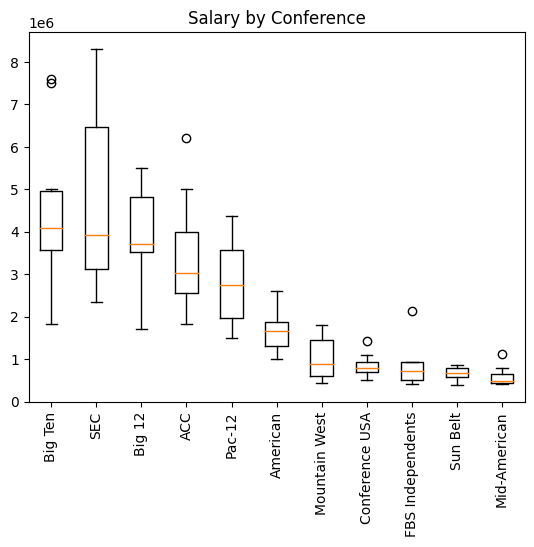

In [ ]:
# boxplots of schoolpay by conference
BigTen = main[main['Conference'] == 'Big Ten']
SEC = main[main['Conference'] == 'SEC' ]
Big12 = main[main['Conference'] == 'Big 12' ]
ACC = main[main['Conference'] == 'ACC' ]
Pac12 = main[main['Conference'] == 'Pac-12' ]
American = main[main['Conference'] == 'American' ]
MountainWest = main[main['Conference'] == 'Mountain West' ]
ConferenceUSA = main[main['Conference'] == 'Conference USA' ]
FBSIndependents = main[main['Conference'] == 'FBS Independents' ]
SunBelt = main[main['Conference'] == 'Sun Belt' ]
MidAmerican = main[main['Conference'] == 'Mid-American' ]

data = [BigTen['SchoolPay'], SEC['SchoolPay'],
    Big12['SchoolPay'], ACC['SchoolPay'],
    Pac12['SchoolPay'], American['SchoolPay'],
    MountainWest['SchoolPay'], ConferenceUSA['SchoolPay'],
    FBSIndependents['SchoolPay'], SunBelt['SchoolPay'],
    MidAmerican['SchoolPay']]

ordered_conference_names = ['Big Ten', 'SEC', 'Big 12', 'ACC', 'Pac-12', 'American', 'Mountain West',
                            'Conference USA', 'FBS Independents', 'Sun Belt', 'Mid-American']

fig, axis = plt.subplots()
#axis.set_xlabel('Conference')
# axis.set_ylabel('SchoolPay')
conference_plot = plt.boxplot(data, sym='o', vert=1, whis=1.5)
plt.setp(conference_plot['boxes'], color = 'black')
plt.setp(conference_plot['whiskers'], color = 'black')
plt.setp(conference_plot['fliers'], color = 'black', marker = 'o')
axis.set_xticklabels(ordered_conference_names)
plt.xticks(rotation=90)
plt.title("Salary by Conference")
plt.show()

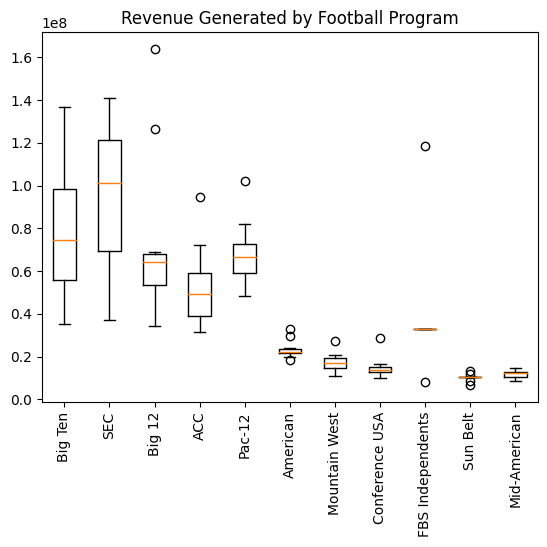

In [ ]:
# boxplots of schoolpay by conference
BigTen = main[main['Conference'] == 'Big Ten']
SEC = main[main['Conference'] == 'SEC' ]
Big12 = main[main['Conference'] == 'Big 12' ]
ACC = main[main['Conference'] == 'ACC' ]
Pac12 = main[main['Conference'] == 'Pac-12' ]
American = main[main['Conference'] == 'American' ]
MountainWest = main[main['Conference'] == 'Mountain West' ]
ConferenceUSA = main[main['Conference'] == 'Conference USA' ]
FBSIndependents = main[main['Conference'] == 'FBS Independents' ]
SunBelt = main[main['Conference'] == 'Sun Belt' ]
MidAmerican = main[main['Conference'] == 'Mid-American' ]

data = [BigTen['Revenues'], SEC['Revenues'],
    Big12['Revenues'], ACC['Revenues'],
    Pac12['Revenues'], American['Revenues'],
    MountainWest['Revenues'], ConferenceUSA['Revenues'],
    FBSIndependents['Revenues'], SunBelt['Revenues'],
    MidAmerican['Revenues']]

ordered_conference_names = ['Big Ten', 'SEC', 'Big 12', 'ACC', 'Pac-12', 'American', 'Mountain West',
                            'Conference USA', 'FBS Independents', 'Sun Belt', 'Mid-American']

fig, axis = plt.subplots()
# axis.set_xlabel('Conference')
# axis.set_ylabel('Revenue')
conference_plot = plt.boxplot(data, sym='o', vert=1, whis=1.5)
plt.setp(conference_plot['boxes'], color = 'black')
plt.setp(conference_plot['whiskers'], color = 'black')
plt.setp(conference_plot['fliers'], color = 'black', marker = 'o')
axis.set_xticklabels(ordered_conference_names)
plt.xticks(rotation=90)
plt.title("Revenue Generated by Football Program")
plt.show()

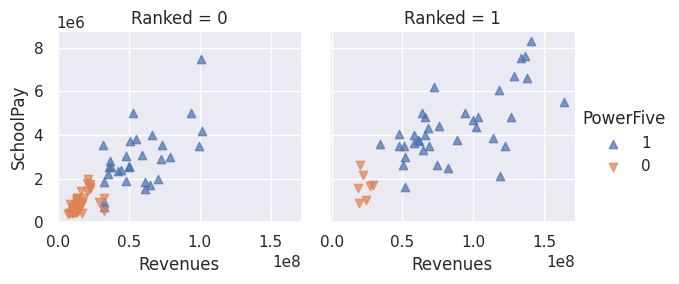

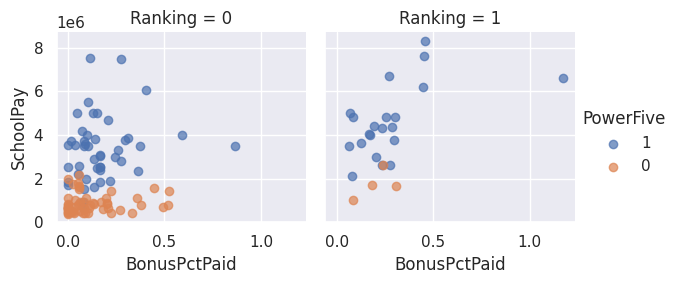

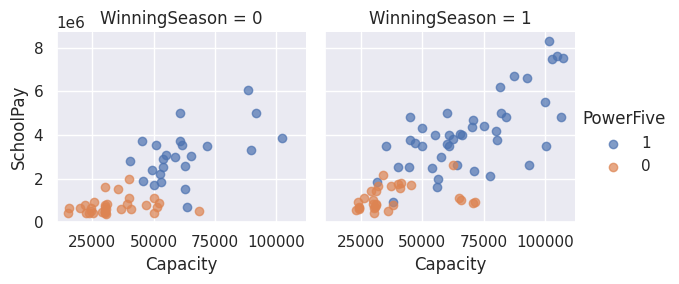

In [ ]:
# scatterplots for various combinations of variables
# code from week 3 asynch

sns.set(style="darkgrid")

g = sns.FacetGrid(main, col="Ranked", hue="PowerFive",
                  hue_order=[1, 0],
                  hue_kws=dict(marker=["^", "v"]))
g.map(plt.scatter, "Revenues", "SchoolPay", alpha=.7)
g.add_legend();
plt.show()

g = sns.FacetGrid(main, col="Ranking", hue="PowerFive",
                hue_order=[1, 0],)
g.map(plt.scatter, "BonusPctPaid", "SchoolPay", alpha=.7)
g.add_legend();
plt.show()

g = sns.FacetGrid(main, col="WinningSeason", hue="PowerFive",
                hue_order=[1, 0],)
g.map(plt.scatter, "Capacity", "SchoolPay", alpha=.7)
g.add_legend();
plt.show()

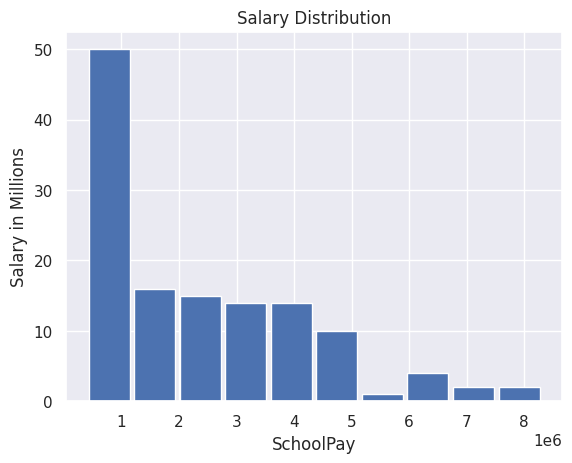

In [ ]:
# histogram of attendance
# code from asynch week 3

plt.hist(main['SchoolPay'], density= False, stacked = False, rwidth = .9)
plt.title("Salary Distribution")
plt.xlabel('SchoolPay')
plt.ylabel('Salary in Millions')

plt.show()

<ipython-input-28-de956f81ee44>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = main.corr()


<Axes: >

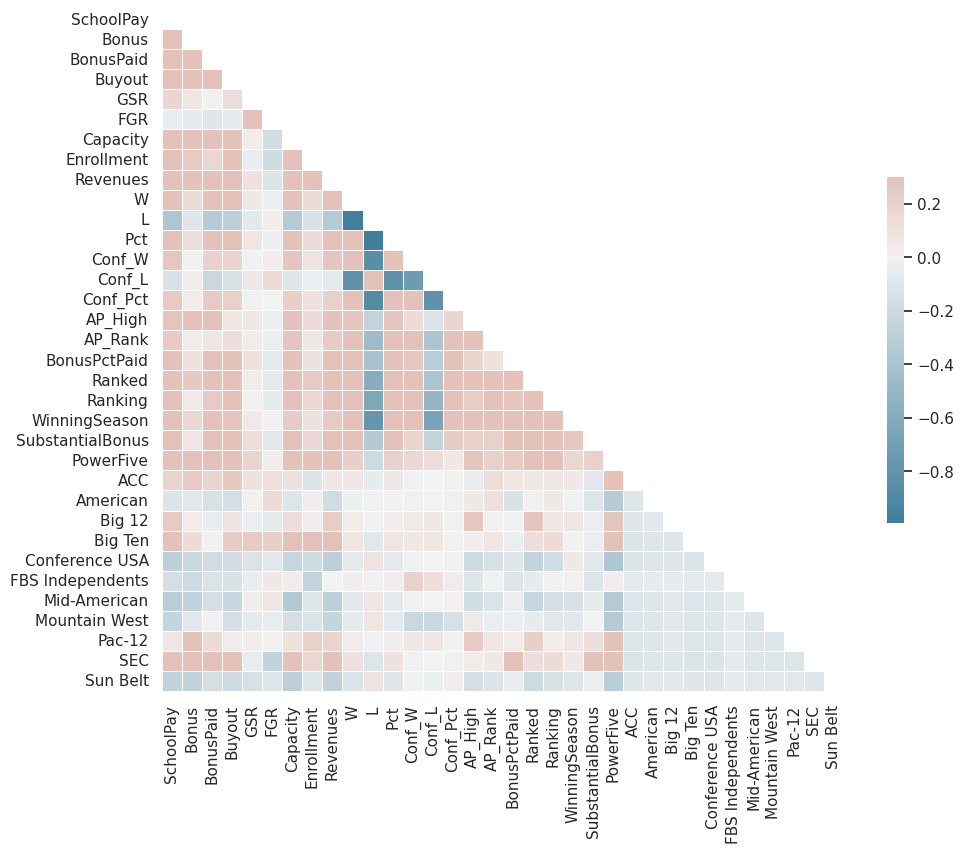

In [ ]:
# code from week3 asynch
# correlation matrix
sns.set_theme(style="white")
corr = main.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# modeling

In [ ]:
# code from week 3 async
# employ training-and-test regimen for model validation
np.random.seed(24)
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_1 = str('SchoolPay ~ BonusPctPaid + FGR + Capacity + Enrollment + Revenues + Pct + Ranked + PowerFive')

# fit the model to the training set
train_model_fit = smf.ols(model_1, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)



main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

<ipython-input-29-857699fec299>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_train['predict_pay'] = train_model_fit.fittedvalues
<ipython-input-29-857699fec299>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_test['predict_pay'] = train_model_fit.predict(main_test)


In [ ]:
# code from week 3 async
# model 2
# using each conference dummy variable instead of power5
# employ training-and-test regimen for model validation
np.random.seed(24)
main = main.rename(columns = {'Big Ten' : 'BigTen', 'Mountain West' : 'MountainWest', 'Mid-American' : 'MidAmerican', 'Conference USA' : 'ConferenceUSA',
       'Sun Belt' : 'SunBelt', 'Pac-12' : 'Pac12', 'FBS Independents' : 'FBSIndependents', 'Big 12' : 'Big12'})
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_2 = str('SchoolPay ~ BonusPctPaid + FGR + Capacity + Enrollment + Revenues + Pct + BigTen + MountainWest + MidAmerican + ConferenceUSA + SunBelt + Pac12 + FBSIndependents + Big12 + SEC + ACC + American')
# fit the model to the training set
train_model_fit = smf.ols(model_2, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)



main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

<ipython-input-30-e7d2bd9cb814>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_train['predict_pay'] = train_model_fit.fittedvalues
<ipython-input-30-e7d2bd9cb814>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_test['predict_pay'] = train_model_fit.predict(main_test)


In [ ]:
# code from week 3 async
# model 3
# using wins instead of pct, power5 instead of each conference
np.random.seed(24)
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_3 = str('SchoolPay ~ BonusPctPaid + FGR + Capacity + Enrollment + Revenues + W + Ranked + PowerFive')
# fit the model to the training set
train_model_fit = smf.ols(model_3, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)


main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

<ipython-input-31-71a222aa07ba>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_train['predict_pay'] = train_model_fit.fittedvalues
<ipython-input-31-71a222aa07ba>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_test['predict_pay'] = train_model_fit.predict(main_test)


In [ ]:
# code from week 3 async
# model 4
# using wins, power5, Ranking instead of Ranked
np.random.seed(24)
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_4 = str('SchoolPay ~ BonusPctPaid + FGR + Capacity + Enrollment + Revenues + W + Ranking + PowerFive')
# fit the model to the training set
train_model_fit = smf.ols(model_4, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)


main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

<ipython-input-32-90267accf856>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_train['predict_pay'] = train_model_fit.fittedvalues
<ipython-input-32-90267accf856>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_test['predict_pay'] = train_model_fit.predict(main_test)


In [ ]:
# code from week 3 async
# model 5
# paring down to the significant or at least lower p-value variables
np.random.seed(24)
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_5 = str('SchoolPay ~ BonusPctPaid + Enrollment + Revenues + W + Ranked + PowerFive')
# fit the model to the training set
train_model_fit = smf.ols(model_5, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)


main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

<ipython-input-33-c7096b5be591>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_train['predict_pay'] = train_model_fit.fittedvalues
<ipython-input-33-c7096b5be591>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_test['predict_pay'] = train_model_fit.predict(main_test)


In [ ]:
# code from week 3 async
# model 6
# only using significant p-value variables
np.random.seed(24)
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_6 = str('SchoolPay ~ BonusPctPaid + Revenues + Enrollment + PowerFive')
# fit the model to the training set
train_model_fit = smf.ols(model_6, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)


main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

<ipython-input-34-17772fe04c42>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_train['predict_pay'] = train_model_fit.fittedvalues
<ipython-input-34-17772fe04c42>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_test['predict_pay'] = train_model_fit.predict(main_test)


In [ ]:
# code from week 3 async
# model 7
# using conferences instead of powerfive so can answer big ten question
# and then just bonuspctpaid, revenues

np.random.seed(24)
main = main.rename(columns = {'Big Ten' : 'BigTen', 'Mountain West' : 'MountainWest', 'Mid-American' : 'MidAmerican', 'Conference USA' : 'ConferenceUSA',
       'Sun Belt' : 'SunBelt', 'Pac-12' : 'Pac12', 'FBS Independents' : 'FBSIndependents', 'Big 12' : 'Big12'})
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_7 = str('SchoolPay ~ BonusPctPaid + Revenues + BigTen + MountainWest + MidAmerican + ConferenceUSA + SunBelt + Pac12 + FBSIndependents + Big12 + SEC + ACC + American')
# fit the model to the training set
# fit the model to the training set
train_model_fit = smf.ols(model_7, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)


main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

<ipython-input-35-9cf4a33fbf37>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_train['predict_pay'] = train_model_fit.fittedvalues
<ipython-input-35-9cf4a33fbf37>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_test['predict_pay'] = train_model_fit.predict(main_test)


# final model

In [ ]:
# code from week 3 async
# model 8, final model
# only using less than 0.05 p-values now
np.random.seed(24)
main['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(main))
main_train = main[main['runiform'] >= 0.33]
main_test = main[main['runiform'] < 0.33]
# check training data frame
print('\nmain_train data frame (rows, columns): ',main_train.shape)
print(main_train.head())
# check test data frame
print('\nmain_test data frame (rows, columns): ',main_test.shape)
print(main_test.head())

# specify a simple model
model_8 = str('SchoolPay ~ BonusPctPaid + Revenues + PowerFive')
# fit the model to the training set
train_model_fit = smf.ols(model_8, data = main_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
main_train['predict_pay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
main_test['predict_pay'] = train_model_fit.predict(main_test)


main_train data frame (rows, columns):  (93, 38)
              School     Conference              Coach  SchoolPay    Bonus  \
0          Air Force  Mountain West       Troy Calhoun     885000   247000   
1              Akron   Mid-American       Terry Bowden     411000   225000   
2            Alabama            SEC         Nick Saban    8307000  1100000   
4  Appalachian State       Sun Belt  Scott Satterfield     712500   295000   
5            Arizona         Pac-12       Kevin Sumlin    1600000  2025000   

   BonusPaid    Buyout   GSR   FGR  Capacity  Enrollment   Revenues   W  L  \
0      50000   1476060  0.89  0.89     52237        4237   16823588   5  7   
1      50000    688500  0.79  0.76     30000       19200   12354872   7  7   
2     500000  33600000  0.86  0.65    101821       38500  140831439  13  1   
4     145000   2160417  0.78  0.60     24150       19100   10198918   9  4   
5     279167  10000000  0.73  0.55     56037       45200   51865116   7  6   

    Pct  Con

<ipython-input-36-c15d66a09e95>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_train['predict_pay'] = train_model_fit.fittedvalues
<ipython-input-36-c15d66a09e95>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_test['predict_pay'] = train_model_fit.predict(main_test)


# predictions

In [ ]:
# predictions
# what should syracuse coach be paid

# coefficients
intercept = 265900
BonusPctPaid = 1604000
Revenues = 0.0315
PowerFive = 810400

# syracuse data
main[main.School == 'Syracuse']
# 101
#for ind, column in enumerate(main.columns):
 #   print(ind, column)
# BonusPctPaid: 20
# Revenues: 11
# PowerFive: 25

values = main.iloc[101, [20,11,25]]

recommended_salary = intercept + BonusPctPaid*values[0] + Revenues*values[1] + PowerFive*values[2]
recommended_salary
# 2750960.4122089553
# so approximatley 2.75 million

# the actual pay in the data is
# 2401206
# approximately 2.4 million

# what would his salary be in the big east?
# we can't make predictions outside the data we sampled
# big east doesn't exist anymore so this would be extrapolation
# however since big east was a power conference, we can conjecture that, assuming we ran this model on data from before the big east broke up
# and power conference was found to be signficant, we can assume his pay would be the same

# what would his salary be in the big ten?
# the same

# however using the model that changes out powerfive for each conference you could find slight differences in what he would be paid for ACC vs Big Ten

Intercept = 745500
BonusPctPaid = 1308000
Revenues = 0.0281
BigTen  = 957100
ACC = 981300

ACC_salary = Intercept + BonusPctPaid*values[0] + Revenues*values[1] + BigTen*0 + ACC*1
print(ACC_salary)
# 3200072.285271642
# 3.200 million
BigTen_salary = Intercept + BonusPctPaid*values[0] + Revenues*values[1] + BigTen*1 + ACC*0
BigTen_salary
# 3175872.285271642
# 3.176 million

# personally though I don't like this model because some of the conferences end up not being statistically significant


3200072.285271642


3175872.285271642

<Axes: >

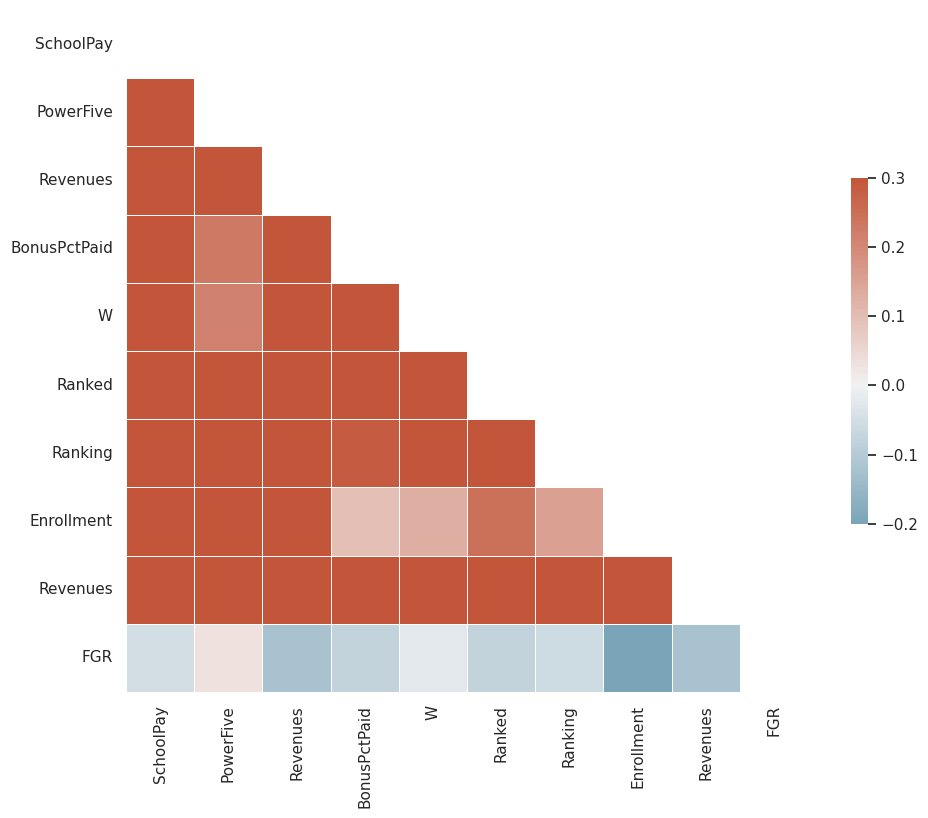

In [ ]:
# heat map of variables of interest

#for ind, column in enumerate(main.columns):
 #   print(ind, column)
# [25, 3, 20, 11, 12, 21, 22, 10, 8]

main_interest = main[['SchoolPay', 'PowerFive', 'Revenues', 'BonusPctPaid', 'W', 'Ranked', 'Ranking', 'Enrollment', 'Revenues', 'FGR']]
# code from week3 asynch
# correlation matrix

sns.set_theme(style="white")
corr = main_interest.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})